In [16]:
from data_loader_asp import AspectDataset, get_dataset, MamsAspectDataset, DataLoaderGen
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from prompts import prompt_dict
import numpy as np
from evaluations_extracted_terms import infer_with_dataset
import pandas as pd
import ast
from selective_generation.semantic_enc import PhraseEncoder
import torch
from matplotlib import pyplot as plt

In [ ]:
LAPTOP_GOLD = '/home/gauneg/llm_experiments/ds_for_generation/dep_laptop_rule_gen_14.csv'
RESTAURANT_GOLD = '/home/gauneg/llm_experiments/ds_for_generation/dep_restaurant_rule_gen_14.csv'
laptop_df = pd.read_csv(LAPTOP_GOLD)
restaurant_df = pd.read_csv(RESTAURANT_GOLD)

# datadict = {'train': df_train.values, 'valid': df_valid.values, 'combined': np.vstack((df_train.values, df_valid.values))}
datadict = {'laptop_gold': laptop_df.values, 'restaurant_gold':restaurant_df.values}

tokenizer = AutoTokenizer.from_pretrained('google/flan-t5-base')


In [6]:
train_ds = get_dataset(DataLoaderGen, datadict, tokenizer, type_path='restaurant_gold', prompt="")

In [7]:
# infer_with_dataset(model, tokenizer, train_ds, file_out='restraunt_train')

In [ ]:
for x in train_ds:
    txt = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(x['input_ids'], skip_special_tokens=True))
    labs = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(x['labels'], skip_special_tokens=True))
    print(f'TEXT: {txt}')
    print(f'LABS: {labs}')

In [13]:
df1 = pd.read_csv('/home/gauneg/llm_experiments/ds_for_generation/dep_restaurant_rule_gen_14.csv')
df2 = pd.read_csv('/home/gauneg/llm_experiments/ds_for_generation/restaurant_train_mams_gen.csv')
df = pd.read_csv('/home/gauneg/llm_experiments/ds_for_generation/restaurant_train.csv')

In [14]:
df2 = df2.drop_duplicates(subset=['text'], keep='last')
df1 = df1.drop_duplicates(subset=['text'], keep='last')
df = df.drop_duplicates(subset=['text'], keep='last')

In [2]:
# p_enc = PhraseEncoder()
# df_lab = pd.read_csv('/home/gauneg/llm_experiments/ds_for_generation/selective_gen_laptop/labelled.csv')
# df_unlab = pd.read_csv('/home/gauneg/llm_experiments/ds_for_generation/selective_gen_laptop/unlabelled.csv')
# rep_arr = p_enc.encode_all(df_lab)
# sim_w_avg = []
# for text, labs in df_unlab.values:
#     sim_w_avg.append(p_enc.calculate_cosine_sim_avg(text))
# df_unlab['lab_sim'] = sim_w_avg
# df_unlab_sorted = df_unlab.sort_values(by=['lab_sim'], ascending=False)
# df_unlab_sorted.to_csv('/home/gauneg/llm_experiments/ds_for_generation/selective_gen_laptop/unlabelled_sim.csv', index=None)
# df_unlab_sorted['lab_sim'].mean()

In [17]:
df_unlab_laptop = pd.read_csv('/home/gauneg/llm_experiments/ds_for_generation/selective_gen_laptop/unlabelled_sim.csv')
df_unlab_restaurant = pd.read_csv('/home/gauneg/llm_experiments/ds_for_generation/selective_gen_restaurant/unlabelled_sim.csv')
all_lap = pd.read_csv('/home/gauneg/llm_experiments/ds_for_generation/laptop_train_twitter_liu_gen.csv')
all_res = pd.read_csv('/home/gauneg/llm_experiments/ds_for_generation/restaurant_train_twitter_liu_gen.csv')

In [18]:
laptop_sim_scores = df_unlab_laptop['lab_sim'].abs()
restaurant_sim_scores = df_unlab_restaurant['lab_sim'].abs()
print('fraction unlabelled:') 
print(f'laptop: {df_unlab_laptop.shape[0]/all_lap.shape[0]}, restaurant: {df_unlab_restaurant.shape[0]/all_res.shape[0]}')
mean_lap = np.round(laptop_sim_scores.mean(), 2)
stand_lap= np.round(np.std(laptop_sim_scores), 2)
mean_res = np.round(restaurant_sim_scores.mean(), 2)
stand_res = np.round(np.std(restaurant_sim_scores), 2)

fraction unlabelled:
laptop: 0.5971128608923885, restaurant: 0.6540735873850198


## Objective

Comparing the similarity distribution across domains.

I.E. Evaluating if the distribution exists in other DS as well

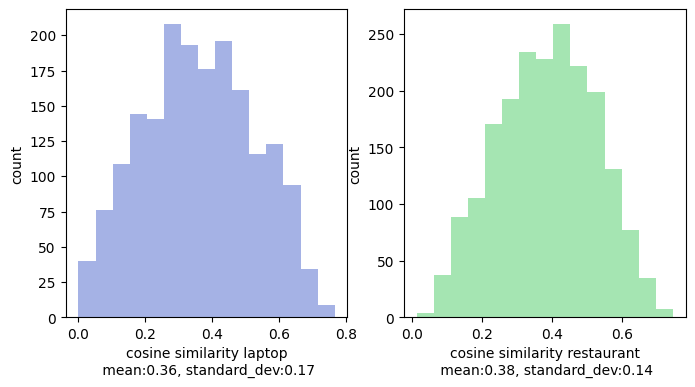

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
axes[0].hist(laptop_sim_scores, bins=15, color=(0.3, 0.4, 0.8, 0.5))

axes[0].set_xlabel(f'cosine similarity laptop\n mean:{mean_lap}, standard_dev:{stand_lap}')
axes[0].set_ylabel('count')

axes[1].hist(restaurant_sim_scores, bins=15, color=(0.3, 0.8, 0.4, 0.5))
axes[1].set_xlabel(f'cosine similarity restaurant\n mean:{mean_res}, standard_dev:{stand_res}')
axes[1].set_ylabel('count')

fig.show()


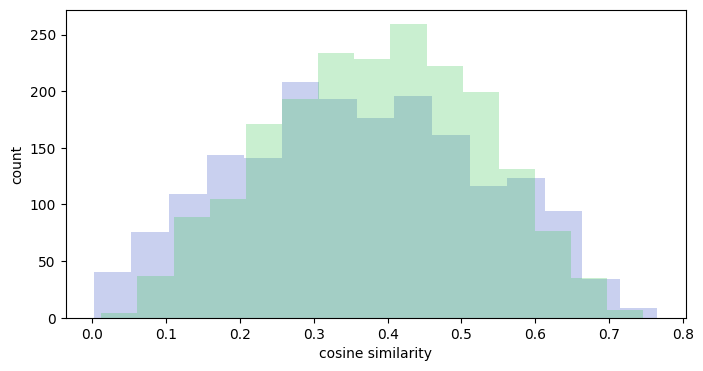

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
axes.hist(laptop_sim_scores, bins=15, color=(0.3, 0.4, 0.8, 0.3))
axes.hist(restaurant_sim_scores, bins=15, color=(0.3, 0.8, 0.4, 0.3))
axes.set_ylabel('count')
axes.set_xlabel('cosine similarity')
fig.show()

## Objective
To count the total values over the cutoff point. To calculate cutoff points:

$$cutoff = \mu - (x \times \sigma), x \in (-1, 0, 1, 2, 3) $$

In [36]:
x =np.arange(-1, 2.5, 0.5)

print('The cutoff values in the laptop dataset')

for xi in x:
    cutoff_val = mean_lap  + (xi * stand_lap)
    if cutoff_val>=1:
        break
    print(f'cutoff values: {cutoff_val}, count: {laptop_sim_scores[laptop_sim_scores>=cutoff_val].shape[0]}')

The cutoff values in the laptop dataset
cutoff values: 0.18999999999999997, count: 1500
cutoff values: 0.27499999999999997, count: 1237
cutoff values: 0.36, count: 905
cutoff values: 0.445, count: 591
cutoff values: 0.53, count: 337
cutoff values: 0.615, count: 137
cutoff values: 0.7, count: 19
